### Local Variance Estimation

When working with time series (observations of a natural sequential ordering) one often wishes to estimate the variance of the time series locally. This notebook will go over a collection of methods that can be utilized to create an estimator for the local variance (or volatility) function

In [1]:

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("../")


PATH = "../../../taq_db/TAQ-Query-Scripts/data/features/2020-01-02/"
sys.path.append(PATH)
DATA_FILE = "AMZN_reconstructed_features.csv"


In [2]:
market_data = pd.read_csv(PATH + DATA_FILE, index_col=0, nrows=20000)
market_data.index = pd.to_datetime(market_data.index)

trade_data= market_data[market_data["Trade_Volume"] > 0]


In [3]:
regular_trades = trade_data[trade_data["Sale_Condition"] == "@   "]
regular_trades.head()

,Date,Exchange,Symbol,Trade_Volume,Trade_Price,Sale_Condition,Source_of_Trade,Trade_Correction_Indicator,Sequence_Number,Trade_Id,...,YearMonth,Imbalance,MOX_Identifier,Effective_Spread,Microprice,Imbalance_Weighted_Effective_Spread,Price_Impact,Realized_Spread,Midprice,Trade_Side
index,,,,,,,,,,,,,,,,,,,,,
2020-01-02 09:30:00.820,2020-01-02,D,AMZN,100.0,1874.5450,@,N,0.0,21402,140.0,...,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:00.948,2020-01-02,D,AMZN,100.0,1874.7425,@,N,0.0,24389,191.0,...,NaN,NaN,128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:00.948,2020-01-02,D,AMZN,100.0,1874.7425,@,N,0.0,24286,185.0,...,NaN,NaN,128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:01.040,2020-01-02,D,AMZN,100.0,1874.7400,@,N,0.0,24778,233.0,...,NaN,NaN,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:01.160,2020-01-02,D,AMZN,200.0,1874.9900,@,N,0.0,26914,252.0,...,NaN,NaN,151.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


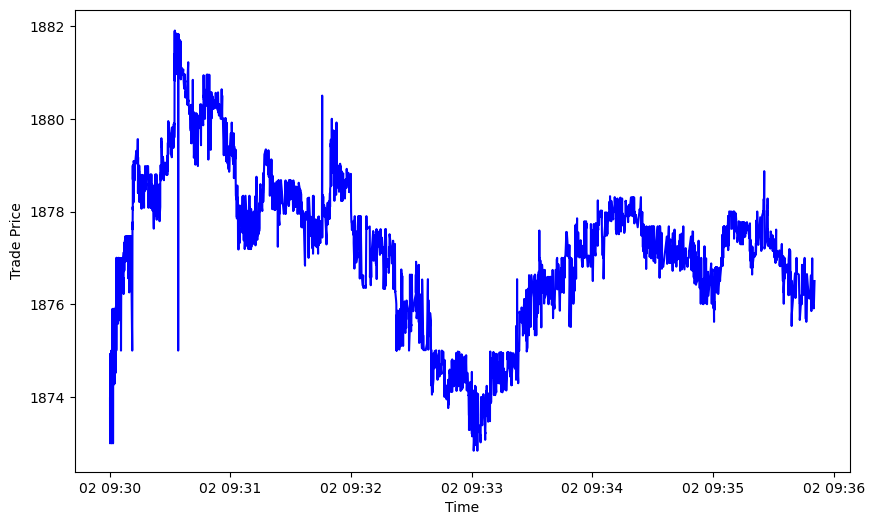

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(trade_data.index, trade_data["Trade_Price"], color="blue", label="Trade Price")

ax.set_xlabel("Time")
ax.set_ylabel("Trade Price")

plt.show()


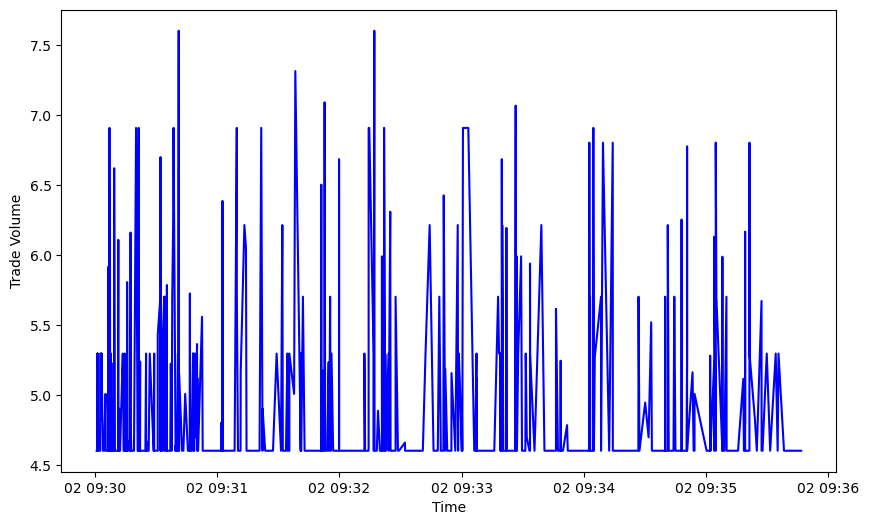

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(regular_trades.index, np.log(regular_trades["Trade_Volume"]), color="blue", label="Trade Volume")

ax.set_xlabel("Time")
ax.set_ylabel("Trade Volume")

plt.show()


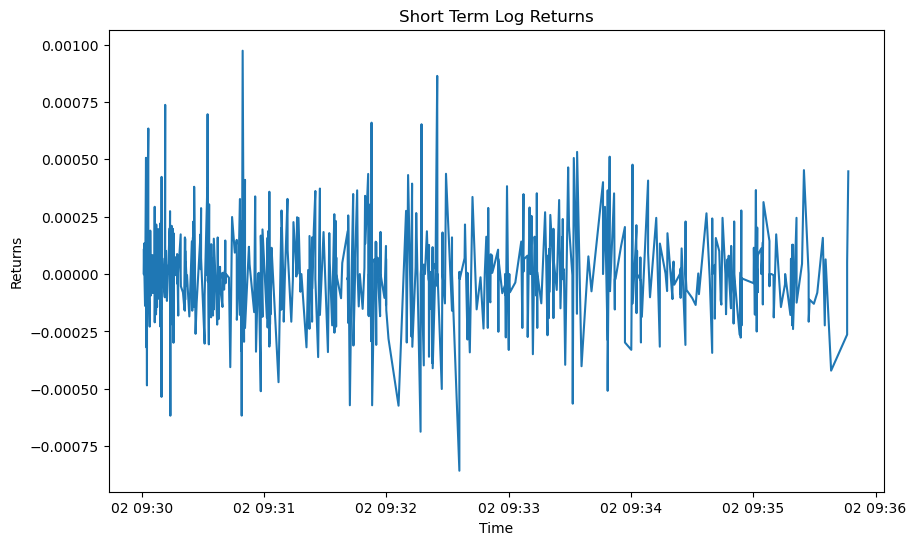

In [6]:
returns= np.log(regular_trades["Trade_Price"][1:].values/regular_trades["Trade_Price"][:-1].values)

returns=pd.Series(returns, index=regular_trades.index[1:])

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(returns)
ax.set_title("Short Term Log Returns")
ax.set_xlabel("Time")
ax.set_ylabel("Returns")
plt.show()


### Local Variance Estimators

Assuming that $E[r_t] = 0$ for all $t$, the local variance of a time series $r_t$ is defined as

$$\sigma^2_t = \frac{1}{T}\sum_{i=1}^T r_i^2$$

where $T$ is the window size. This is the most basic estimator of the local variance, and is often referred to as the "naive" estimator. It is also known as the "sample variance" estimator. The sample variance estimator is unbiased, but has high variance. This is because the variance of the sample mean is proportional to $1/T$, and the variance of the sample variance is proportional to $1/T^2$. This means that the variance of the sample variance is proportional to $1/T$, which is why the sample variance estimator has high variance.

In [7]:
def sample_variance(returns, T):

    def compute_sample_variance(x):
        return (x**2).sum() / (T )
    return returns.rolling(T).apply(lambda x: compute_sample_variance(x))

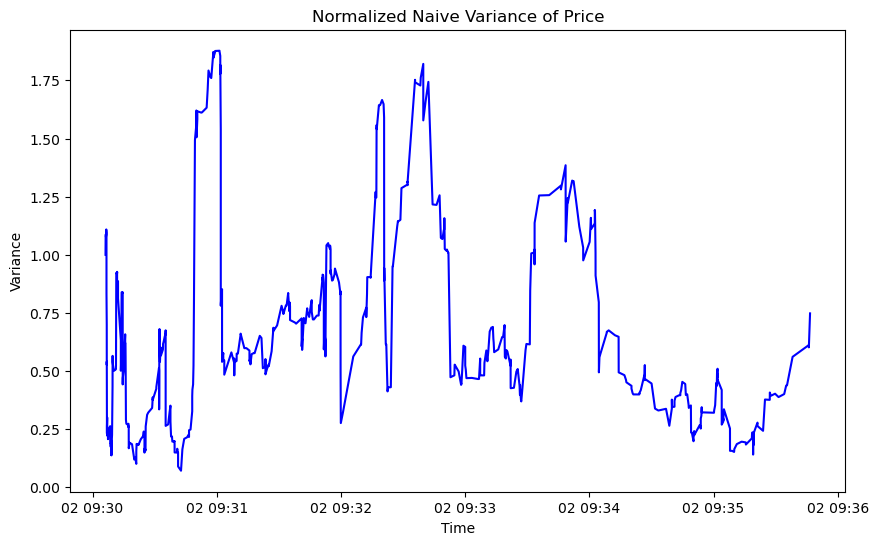

In [8]:
naive_variance = sample_variance(returns, 25).dropna()

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(naive_variance.index, naive_variance.values/naive_variance.values[0], color="blue", label="Naive Variance")
ax.set_title("Normalized Naive Variance of Price")
ax.set_xlabel("Time")
ax.set_ylabel("Variance")
plt.show()



### Trade Volume

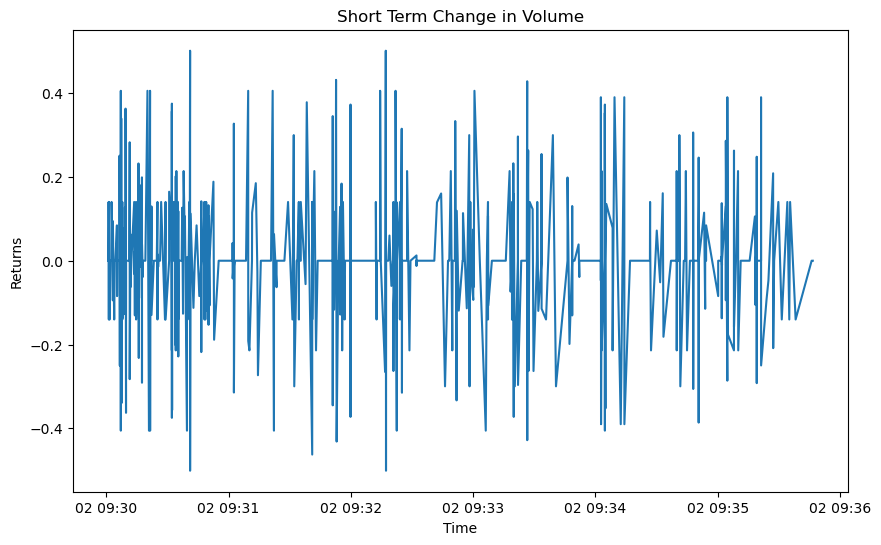

In [9]:
volume_returns = np.log(np.log(regular_trades["Trade_Volume"][1:].values)/np.log(regular_trades["Trade_Volume"][:-1].values))

volume_returns = pd.Series(volume_returns, index=regular_trades.index[1:])

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(volume_returns)
ax.set_title("Short Term Change in Volume")
ax.set_xlabel("Time")
ax.set_ylabel("Returns")
plt.show()


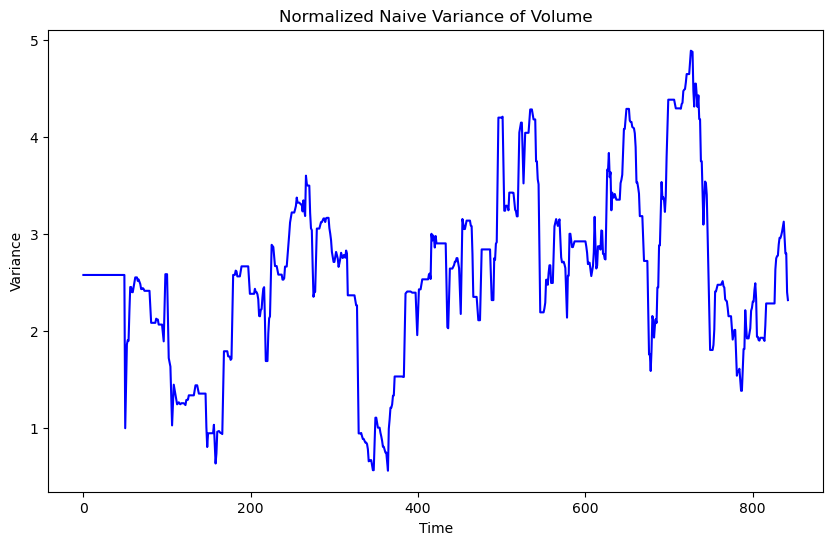

In [10]:
naive_volume_variance = sample_variance(volume_returns, 50).dropna()

volume_local_variance=naive_volume_variance/naive_volume_variance.values[0]

volume_local_variance=np.pad(volume_local_variance, (50,0), 'mean')

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot( volume_local_variance, color="blue", label="Naive Variance")
ax.set_title("Normalized Naive Variance of Volume")
ax.set_xlabel("Time")
ax.set_ylabel("Variance")
plt.show()



### Projecting the local variance estimator to much lower dimensional subspace (piecewise constant)

One way we can adaptively filter is by estimating the local variance of the exogenous covariate as a piecewise constant series. Using the TF to select optimal knots, one can then apply a DP search algorithm to select model

In [12]:
from model_selection.partition import partition_solver

from model_selection.model_selection import ratio_model_selection


In [13]:
candidate_knots=np.arange(0,len(volume_local_variance),15)

partition_solver(volume_local_variance,candidate_knots,10,0)

{1: [1],
 2: [1, 15],
 3: [1, 15, 30],
 4: [1, 15, 30, 45],
 5: [1, 15, 30, 45, 840],
 6: [1, 15, 30, 105, 150, 165],
 7: [1, 15, 30, 45, 105, 150, 165],
 8: [1, 15, 30, 45, 105, 120, 150, 165],
 9: [1, 15, 30, 45, 105, 120, 135, 150, 165],
 10: [1, 15, 30, 45, 105, 120, 135, 150, 165, 840],
 0: []}

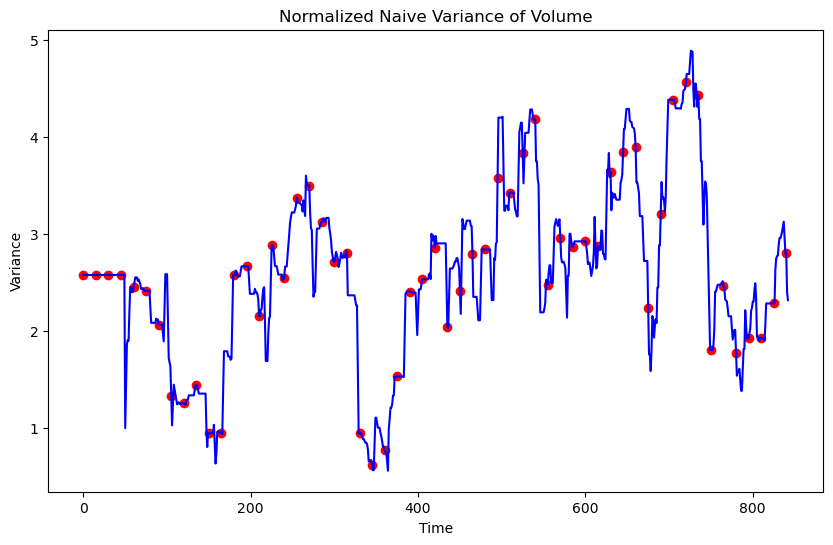

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot( volume_local_variance, color="blue", label="Naive Variance")
ax.set_title("Normalized Naive Variance of Volume")

ax.set_xlabel("Time")
ax.set_ylabel("Variance")

ax.scatter(candidate_knots, volume_local_variance[candidate_knots], color="red", label="Candidate Knots")

### Regression Trees

In [15]:
from sklearn import tree


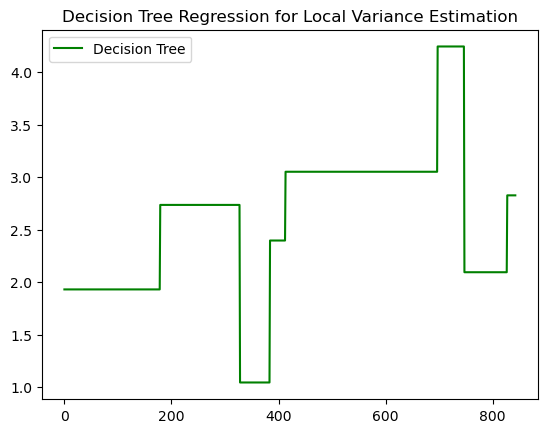

In [16]:
model=tree.DecisionTreeRegressor(max_depth=3)

model.fit(np.arange(len(volume_local_variance)).reshape(-1,1), volume_local_variance)

predictions=model.predict(np.arange(len(volume_local_variance)).reshape(-1,1))

plt.title("Decision Tree Regression for Local Variance Estimation")

plt.plot(np.arange(len(volume_local_variance)), predictions, color="green", label="Decision Tree")

plt.legend()

### Effect of Volume Variance on Trend Filtering

In [17]:
from matrix_algorithms.difference_matrix import Difference_Matrix
from trend_filtering.cv_tf import cross_validation
from trend_filtering.adaptive_tf import adaptive_tf

In [18]:
trade_price=regular_trades["Trade_Price"].values

D=Difference_Matrix(len(trade_price),k=1)
best_lambda=cross_validation(trade_price.reshape(-1,1), D,cv_folds=15,cv_iterations=3,verbose=True)

print(f"Best lambda: {best_lambda}")

results=adaptive_tf(trade_price.reshape(-1,1), D, best_lambda,select_knots=True)

Performing  0 out of 3 iterations of cross validation
Performing cross validation for lambda = 2.908784776606172
Performing cross validation for lambda = 5.6159841620037065
Performing cross validation for lambda = 10.842767867024856
Performing cross validation for lambda = 20.93410729567319
Performing cross validation for lambda = 40.41743341195449
Performing cross validation for lambda = 78.03384689575051
Performing cross validation for lambda = 150.6597709776489
Performing cross validation for lambda = 290.8784776606172
Performing cross validation for lambda = 561.5984162003707
Performing cross validation for lambda = 1084.2767867024857
Performing cross validation for lambda = 2093.4107295673166
Performing cross validation for lambda = 4041.7433411954494
Performing cross validation for lambda = 7803.384689575051
Performing cross validation for lambda = 15065.977097764873
Performing cross validation for lambda = 29087.84776606172
Performing  1 out of 3 iterations of cross validation
P

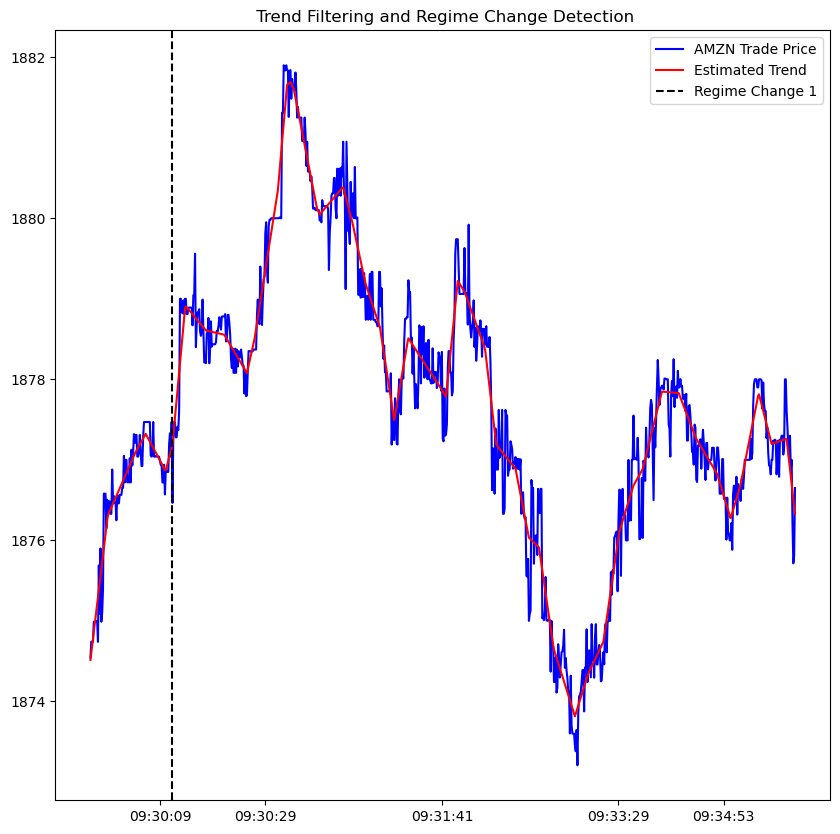

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(trade_price, label="AMZN Trade Price",color='blue')
ax.plot(results["sol"].x, label="Estimated Trend ",color='red')

for i in range(len(results["sol"].knots)):
    ax.axvline(results["sol"].knots[i],color='black',linestyle='--',label=f"Regime Change {i+1}")

ax.legend()
ax.set_title(" Trend Filtering and Regime Change Detection")

quantiles=[0.1,0.25,0.5,0.75,0.9]
indices=[int(len(trade_price)*q)-1 for q in quantiles]
ax.set_xticks(indices,regular_trades.index[indices].strftime("%H:%M:%S"))

### Adaptive Trend Filtering

In [20]:
trade_price=regular_trades["Trade_Price"].values

D=Difference_Matrix(len(trade_price),k=1,prior=1/predictions/np.mean(1/predictions))
best_lambda=cross_validation(trade_price.reshape(-1,1), D,cv_folds=15,cv_iterations=3,verbose=True)

print(f"Best lambda: {best_lambda}")

results=adaptive_tf(trade_price.reshape(-1,1), D, best_lambda,select_knots=True)

Performing  0 out of 3 iterations of cross validation
Performing cross validation for lambda = 3.2729681673415967
Performing cross validation for lambda = 6.319112207393592
Performing cross validation for lambda = 12.200295587373226
Performing cross validation for lambda = 23.555082982245846
Performing cross validation for lambda = 45.477745217478535
Performing cross validation for lambda = 87.80377940611687
Performing cross validation for lambda = 169.52255748675586
Performing cross validation for lambda = 327.2968167341597
Performing cross validation for lambda = 631.9112207393592
Performing cross validation for lambda = 1220.0295587373228
Performing cross validation for lambda = 2355.508298224582
Performing cross validation for lambda = 4547.774521747853
Performing cross validation for lambda = 8780.377940611688
No solution found for lambda = 8780.377940611688
Status: maxiter exceeded
Performing cross validation for lambda = 16952.25574867557
No solution found for lambda = 16952.255

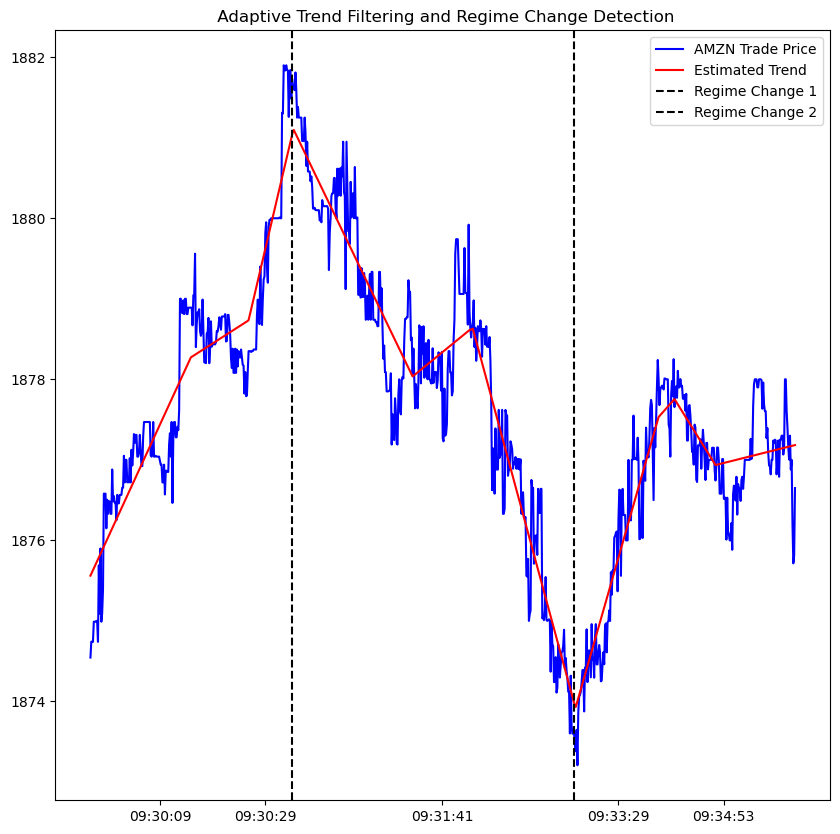

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(trade_price, label="AMZN Trade Price",color='blue')
ax.plot(results["sol"].x, label="Estimated Trend ",color='red')

for i in range(len(results["sol"].knots)):
    ax.axvline(results["sol"].knots[i],color='black',linestyle='--',label=f"Regime Change {i+1}")

ax.legend()
ax.set_title(" Adaptive Trend Filtering and Regime Change Detection")

quantiles=[0.1,0.25,0.5,0.75,0.9]
indices=[int(len(trade_price)*q)-1 for q in quantiles]
ax.set_xticks(indices,regular_trades.index[indices].strftime("%H:%M:%S"))

In [22]:
results["sol"].get_knots()

{1: [119], 2: [241, 578], 3: [241, 456, 578], 4: [241, 384, 456, 578], 5: [188, 241, 384, 456, 578], 0: []}


([241, 578],
 [(2, 0.5628551616833888),
  (1, 0.7290598548258799),
  (4, 0.7944732328377551),
  (3, 0.8052866701118286),
  (5, 0.9506213244966665),
  (0, 1.0)])